# Connect and authorize google drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !ls

# Download data

In [ ]:
!wget -O galah_dr4_allstar_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_allstar_240705.fits
!wget -O galah_dr4_vac_dynamics_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_vac_dynamics_240705.fits
!wget -O ONeill2024_LocalBubble_Shell_xyz.fits https://dataverse.harvard.edu/api/access/datafile/8955365
# !wget -O ONeill2024_LocalBubble_ShellProperties_A0.5.fits https://dataverse.harvard.edu/api/access/datafile/8943783

# Install

In [ ]:
# ! pip install healpy --quiet

In [ ]:
# ! pip install wget --quiet

# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable ## for Plotting L.O.S Samples
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.6.0+cu124
torch.version.cuda:  12.4
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/GASKAP

/content/gdrive/MyDrive/Colab Notebooks/GASKAP


# Fcn

In [ ]:
vlsr_sun = 15.17 # km/s, see Sven's paper GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def plot_star_hi_abs(GASS_nhi_thin_map, glon_cnm, glat_cnm, glon_det, glat_det, hi_det_src_id, closest_coords_glon, closest_coords_glat):
    xlbs = 18
    tlbs = 16
    cmap = 'viridis'
    cmap = 'bwr'

    cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


    # Plot
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection=w)

    # Display the moment map image
    im = ax.imshow(GASS_nhi_thin_map, cmap='gray')
    # ax.invert_yaxis()  # Flips the Y axis
    # ax.invert_xaxis()  # Flips the X axis


    sct = ax.scatter(glon_cnm, glat_cnm, s=40, c=vcencnm, transform=ax.get_transform('galactic'),
              marker='o', cmap=cmap, # vmin=-10, vmax=10., # norm=mpl.colors.LogNorm(vmin=0.01, vmax=0.2), # vmin=0.01, vmax=0.06, # vmax=n_k_is.max(),
              label='HI absorption detections')
    ax.scatter(glon_det[hi_det_src_id], glat_det[hi_det_src_id], s=150, transform=ax.get_transform('galactic'), marker='x', c='c', alpha=0.8, label='Absorption L.O.S')
    ax.scatter(closest_coords_glon, closest_coords_glat, s=110, transform=ax.get_transform('galactic'), marker='*', c='magenta', alpha=0.8, label='Star')

    ax.plot(ch_xcirc, ch_ycirc,
            transform=ax.get_transform('galactic'),
            lw=3.5,
            c='lightcyan',
            ls='--',
            zorder=0,
            alpha=0.5,
            label='Horizontal filament'
          )

    ax.plot(cv_xcirc, cv_ycirc,
            transform=ax.get_transform('galactic'),
            lw=3.5,
            c='gray',
            ls='--',
            alpha=0.5,
            zorder=0,
            label='Vertical filament'
          )


    # Approximate locations of LMC, SMC
    ax.plot(SMC_xcirc,
            SMC_ycirc,
            transform=ax.get_transform('galactic'),
            lw=2.,
            color='r',
            ls='--',
            label='Toward SMC'
          )
    ax.plot(LMC_xcirc,
            LMC_ycirc,
            transform=ax.get_transform('galactic'),
            lw=2.,
            color='y',
            ls='--',
            label='Toward LMC'
          )



    # Title
    # ax.set_title('', fontsize=18)

    # Add axes labels
    ax.set_xlabel('Galactic Longitude [degrees]', fontsize=xlbs)
    ax.set_ylabel('Galactic Latitude [degrees]', fontsize=xlbs)

    # Color bar
    cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.01, pad=0.006, aspect=55)
    cbar.ax.set_ylabel('CNM Velocity [km/s]', rotation=90, labelpad=5., fontsize=15)
    cbar.ax.tick_params(labelsize=16)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=tlbs, pad=4)
    ax.tick_params(axis='y', labelsize=tlbs)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=4)


    ax.legend(loc='upper left', fontsize=16)

    plt.grid(color='gray', lw=0.5)
    plt.show()

In [ ]:
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def download_galah_data(save_path, sobject_id):
    sobject_id = str(sobject_id)
    output_star_id_file = save_path / f'{sobject_id}_allstar_fit_spectrum.fits'
    # print(output_star_id_file)
    save_path = str(save_path)

    if not os.path.exists(output_star_id_file):
        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_spectrum.fits'
        wget.download(url, out=save_path)

        url = f'https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/{sobject_id[:6]}/{sobject_id}/{sobject_id}_allstar_fit_comparison.pdf'
        wget.download(url, out=save_path)

In [ ]:
def rv_to_lsr(ra, dec, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Parameters:
    -----------
    ra : float or array-like
        Right Ascension in degrees
    dec : float or array-like
        Declination in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Create SkyCoord object
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

    # Convert to Galactic coordinates
    l = coords.galactic.l.radian
    b = coords.galactic.b.radian

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr







def rv_to_lsr_lb(glon, glat, rv, u_sun=11.10, v_sun=12.24, w_sun=7.25):
    """
    Convert heliocentric radial velocities to the Local Standard of Rest (LSR).

    Schönrich et al. (2010): https://academic.oup.com/mnras/article/403/4/1829/1054839
    and https://www.aanda.org/articles/aa/pdf/2024/09/aa50936-24.pdf

    Parameters:
    -----------
    glon : float or array-like
        Galactic longitude in degrees
    glat : float or array-like
        Galactic latitude in degrees
    rv : float or array-like
        Heliocentric radial velocity in km/s
    u_sun : float, optional
        Solar motion in km/s toward the Galactic center
    v_sun : float, optional
        Solar motion in km/s in direction of Galactic rotation
    w_sun : float, optional
        Solar motion in km/s toward the North Galactic Pole

    Returns:
    --------
    float or array-like
        Radial velocity in the LSR frame in km/s
    """
    # Convert to Galactic coordinates
    l = np.radians(glon)
    b = np.radians(glat)

    # Calculate projection of solar motion
    proj_sun_vel = (
        u_sun * np.cos(b) * np.cos(l) +
        v_sun * np.cos(b) * np.sin(l) +
        w_sun * np.sin(b)
    )

    # Convert to LSR
    rv_lsr = rv + proj_sun_vel

    return rv_lsr

In [ ]:
def wavelength_to_rv(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity from observed and rest wavelengths using the
    relativistic Doppler formula.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    # Convert wavelengths to float if they're strings
    wavelength_obs = np.float64(wavelength_obs)
    wavelength_rest = np.float64(wavelength_rest)

    # Calculate velocity using relativistic formula
    c = const.c.to('km/s').value  # speed of light in km/s

    # (λ_obs / λ_rest)^2 = (1 + v/c)/(1 - v/c)
    # Solving for v:
    z = wavelength_obs / wavelength_rest
    rv = c * (z**2 - 1) / (z**2 + 1)

    return rv

def wavelength_to_rv_simple(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity using the simple (non-relativistic) Doppler formula.
    Use this only for v << c.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    c = const.c.to('km/s').value  # speed of light in km/s

    # Simple Doppler formula: v/c = Δλ/λ
    # rv = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    rv = c * (wavelength_obs - wavelength_rest) / wavelength_obs

    return rv

In [ ]:
def wavelength_to_vlsrk(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def wavelength_to_vlsrk_with_galah_correction(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        galah_allstar['rv_comp_1']: See GALAH
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths) + rv_comp_1
    # vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk


# vlsrk_velocities = wavelength_to_vlsrk(observed_wavelengths_angstroms, rest_wavelength_angstroms, galactic_l, galactic_b)

In [ ]:
def binned_avg(x: np.ndarray, y: np.ndarray, bin_edges: np.ndarray, n_resamples = 1000):
    from scipy import stats

    # Calculate the bin average using scipy
    bin_avg, _, _ = stats.binned_statistic(x, y, statistic='mean', bins=bin_edges)

    # Container for bin averages
    bin_avg_arr = []

    # Perform bootstrap resampling and calculate bin averages
    for _ in range(n_resamples):
        resample_indices = np.random.choice(len(y), size=len(y), replace=True)
        resample_y= y[resample_indices]
        bin_avg_resample, _, _ = stats.binned_statistic(x, resample_y, statistic='mean', bins=bin_edges)
        bin_avg_arr.append(bin_avg_resample)

    # Compute the upper and lower percentiles of the bin averages
    bin_avg_arr = np.array(bin_avg_arr)
    bin_mean_arr = np.mean(bin_avg_arr, axis=0)
    bin_avg_upper = np.percentile(bin_avg_arr, 97.5, axis=0) - bin_mean_arr + bin_avg
    bin_avg_lower = np.percentile(bin_avg_arr, 2.5, axis=0) - bin_mean_arr + bin_avg

    return bin_avg, bin_avg_upper, bin_avg_lower

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def normalize_spectrum(spectrum):
    min_val = np.min(spectrum)
    max_val = np.max(spectrum)

    # Handle the case where all values are the same
    if max_val == min_val:
        return np.zeros_like(spectrum)  # Return a spectrum of zeros or any consistent value

    # Apply min-max normalization
    normalized_spectrum = (spectrum - min_val) / (max_val - min_val)
    return normalized_spectrum

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    # f = 0.3393  # Oscillator strength
    f = 0.332 # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom lambda_rest = 7698.9643 # Angstroms

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

In [ ]:
def mollweide_histogram(ra, dec, distance, eq_width, bin_size=1000, nside=32):
    """
    Plots a histogram in Mollweide projection using HEALPix binning that shows the median
    equivalent width for bins of distances, in galactic coordinates.

    Parameters:
    - ra (array): Right ascension in degrees.
    - dec (array): Declination in degrees.
    - distance (array): Distance in parsec.
    - eq_width (array): Equivalent width in Å.
    - bin_size (int, optional): The size of the distance bins. Default is 200 parsecs.
    - nside (int, optional): The resolution of the HEALPix map. Default is 32.
    """
    # Convert equatorial coordinates (RA, Dec) to galactic coordinates (l, b)
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    l = c.galactic.l.degree
    b = c.galactic.b.degree

    # Convert (l, b) to HEALPix indices
    indices = hp.ang2pix(nside, l, b, lonlat=True)

    # Get maximum distance for binning
    max_dist = np.max(distance)

    # Create bins for distances
    bins = np.arange(0, max_dist + bin_size, bin_size)

    for i in range(len(bins) - 1)[:2]:
        mask = (distance >= 0) & (distance < bins[i+1])
        if np.any(mask):
            median_map = np.full(hp.nside2npix(nside), np.nan)
            for ind in np.unique(indices[mask]):
                median_map[ind] = np.median(eq_width[(indices == ind) & mask])

            hp.mollview(
                median_map,
                title=f'N(KI) 7699',
                cmap='plasma',
                min=7,max=21,
                badcolor='None',
                bgcolor='None',
                unit = r'N(KI) 7699 / $10^{10}\,\mathrm{cm^{-2}}$'
            )
            hp.graticule()

            plt.savefig('figures/n_k_'+str(i)+'.png',dpi=200,bbox_inches='tight', transparent=True)
            plt.show()
            plt.close()

In [ ]:
def create_parallel_uncertainty_lines(x, y, x_err, confidence=0.95):
    """
    Create uncertainty envelope by plotting the outermost lines on both sides of the 1:1 line.

    Parameters:
    -----------
    x : array-like
        X values of data points
    y : array-like
        Y values of data points
    x_err : array-like
        Error values for X data points
    confidence : float, default=0.95
        Confidence level for the envelope (0-1)
    ax : matplotlib.axes.Axes, optional
        Axes to plot on, if None, a new figure is created

    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure containing the plot
    ax : matplotlib.axes.Axes
        Axes containing the plot
    """

    # Convert inputs to numpy arrays
    x = np.array(x)
    y = np.array(y)
    x_err = np.array(x_err)

    # Calculate z-score for the given confidence level
    z = stats.norm.ppf((1 + confidence) / 2)

    # Sort data by x values for proper line creation
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    x_err_sorted = x_err[sort_idx]

    # For visualizing the envelope boundaries, create extended x range
    x_min = min(x_sorted - x_err_sorted)
    x_max = max(x_sorted + x_err_sorted)
    extension = (x_max - x_min) * 0.1  # Extend by 10% on each side
    x_extended = np.array([x_min - extension, x_max + extension])

    # Calculate the maximum positive deviation from 1:1 line
    max_positive_dev = max(y_sorted - x_sorted + z * x_err_sorted)

    # Calculate the maximum negative deviation from 1:1 line
    max_negative_dev = min(y_sorted - x_sorted - z * x_err_sorted)

    # Create the upper and lower boundary lines that are parallel to the 1:1 line
    y_upper = x_extended + max_positive_dev
    y_lower = x_extended + max_negative_dev

    return x_extended, y_lower, y_upper

In [ ]:
def get_angular_distance(glon_src, glat_src, star_glon, star_glat):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    star_glon_rad = np.radians(star_glon)
    star_glat_rad = np.radians(star_glat)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distance_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(star_glat_rad) +
        np.cos(glat_src_rad) * np.cos(star_glat_rad) *
        np.cos(glon_src_rad - star_glon_rad)
    )

    # Convert distances back to degrees
    angular_distance = np.degrees(angular_distance_rad)

    return angular_distance

In [ ]:
def find_nearby_stars(glon_src, glat_src, stars_glon, stars_glat, star_ids, radius_deg):
    """
    Find stars within a specified angular radius of a source position in Galactic coordinates.

    Parameters:
    -----------
    glon_src : float
        Galactic longitude of the source in degrees
    glat_src : float
        Galactic latitude of the source in degrees
    stars_glon : array-like
        Galactic longitudes of stars in degrees
    stars_glat : array-like
        Galactic latitudes of stars in degrees
    star_ids : array-like
        Identifiers for each star
    radius_deg : float
        Search radius in degrees

    Returns:
    --------
    nearby_ids : numpy array
        IDs of stars within the search radius
    nearby_coords : dict
        Dictionary containing coordinates and distances of nearby stars:
        - 'glon': Galactic longitudes
        - 'glat': Galactic latitudes
        - 'distances': Angular distances in degrees
    """

    # Convert everything to radians for spherical trig calculations
    glon_src_rad = np.radians(glon_src)
    glat_src_rad = np.radians(glat_src)
    stars_glon_rad = np.radians(stars_glon)
    stars_glat_rad = np.radians(stars_glat)
    radius_rad = np.radians(radius_deg)

    # Use the spherical law of cosines to find angular distances
    # cos(c) = sin(lat1)sin(lat2) + cos(lat1)cos(lat2)cos(lon1-lon2)
    angular_distances_rad = np.arccos(
        np.sin(glat_src_rad) * np.sin(stars_glat_rad) +
        np.cos(glat_src_rad) * np.cos(stars_glat_rad) *
        np.cos(glon_src_rad - stars_glon_rad)
    )

    # Convert distances back to degrees
    angular_distances = np.degrees(angular_distances_rad)

    # Create boolean mask for stars within radius
    mask = angular_distances < radius_deg

    # Collect results for nearby stars
    nearby_coords = {
        'glon': stars_glon[mask],
        'glat': stars_glat[mask],
        'distances': angular_distances[mask],
        'ki_ew_ism': galah['ew_k_is'][mask]
    }

    nearby_ids = star_ids[mask]

    return nearby_ids, nearby_coords

# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)

# SMC_xcirc = _circle(305., -41, 3.),
# LMC_xcirc = _circle(277., -33.5, 6.)






# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

# glon = np.arange(270., 307., 0.1)
# glat = np.arange(-48., -25., 0.1)
lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

# lmc_glon = [270., 309.]
# lmc_glat = [-48.25, -26.95]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
8,24,J004327-704135,SB30665_component_11a,10.863942,-70.693260,303.888848,-46.420157,B,215.136993,332.138000,...,5.895,131.210007,2.227711e+20,False,0.000643,M344-11,30665,30665,False,False
10,26,J013229-723956,SB30665_component_12a,23.123198,-72.665757,298.690805,-44.122841,B,138.602005,138.981995,...,4.800,127.029999,1.083733e+21,False,0.002100,M344-06,30665,30665,False,False
11,28,J002919-754018,SB30665_component_13a,7.330447,-75.671738,304.752927,-41.378221,B,185.477005,206.205994,...,4.860,7.050000,1.705849e+20,False,0.002592,M344-11,30665,30665,False,False
12,29,J002920-754008,SB30665_component_13b,7.334793,-75.668999,304.751919,-41.381065,B,70.438004,70.567001,...,4.735,156.479996,1.705849e+20,False,0.000732,M344-11,30665,30665,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,0,J045631-762533,SB38845_component_245a,74.132371,-76.425960,288.737278,-32.932020,C,18.582001,20.014000,...,4.195,40.980000,0.000000e+00,False,-0.001994,M000-02,"38509,38845",38845,False,False
2710,0,J045907-753153,SB38845_component_261a,74.779860,-75.531478,287.674258,-33.105855,C,17.294001,21.070000,...,4.570,51.529999,0.000000e+00,False,-0.000745,M000-02,"38758,38845",38845,False,False
2711,0,J045340-751015,SB38758_component_264a,73.419855,-75.170876,287.418567,-33.556039,C,15.995000,17.537001,...,4.195,57.150002,0.000000e+00,False,0.004325,M000-02,"38758,38845",38758,False,False
2712,0,J060302-715904,SB33047_component_273a,90.760142,-71.984682,282.615941,-29.427549,C,16.532000,17.809999,...,3.845,84.059998,0.000000e+00,False,-0.017450,M000-02,"33047,38845",33047,False,False


# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425,132.397995,0.362214,0.028466
2,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
3,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467,49.803001,0.380017,0.057622
4,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508,61.556000,0.393059,0.018767


In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
galah0 = Table.read(allstar_file)
med_dist_lim = 3000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
print(galah0.columns)

<TableColumns names=('sobject_id','tmass_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec','flag_sp','flag_sp_fit','opt_loop','flag_red','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4','chi2_sp','px_used_perc','model_name','closest_model','comp_time','fit_global_rv','rv_comp_1','e_rv_comp_1','rv_comp_2','e_rv_comp_2','rv_gaia_dr3','e_rv_gaia_dr3','v_bary_eff','teff','e_teff','logg','e_logg','fe_h','e_fe_h','flag_fe_h','vmic','e_vmic','vsini','e_vsini','nn_li_fe','nn_e_li_fe','nn_flag_li_fe','c_fe','e_c_fe','flag_c_fe','n_fe','e_n_fe','flag_n_fe','o_fe','e_o_fe','flag_o_fe','na_fe','e_na_fe','flag_na_fe','mg_fe','e_mg_fe','flag_mg_fe','al_fe','e_al_fe','flag_al_fe','si_fe','e_si_fe','flag_si_fe','k_fe','e_k_fe','flag_k_fe','ca_fe','e_ca_fe','flag_ca_fe','sc_fe','e_sc_fe','flag_sc_fe','ti_fe','e_ti_fe','flag_ti_fe','v_fe','e_v_fe','flag_v_fe','cr_fe','e_cr_fe','flag_cr_fe','mn_fe','e_mn_fe','flag_mn_fe','co_fe','e_co_fe','flag_co_fe','ni_fe','e_ni_fe','fla

In [ ]:
galah0.columns

<TableColumns names=('sobject_id','tmass_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec','flag_sp','flag_sp_fit','opt_loop','flag_red','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4','chi2_sp','px_used_perc','model_name','closest_model','comp_time','fit_global_rv','rv_comp_1','e_rv_comp_1','rv_comp_2','e_rv_comp_2','rv_gaia_dr3','e_rv_gaia_dr3','v_bary_eff','teff','e_teff','logg','e_logg','fe_h','e_fe_h','flag_fe_h','vmic','e_vmic','vsini','e_vsini','nn_li_fe','nn_e_li_fe','nn_flag_li_fe','c_fe','e_c_fe','flag_c_fe','n_fe','e_n_fe','flag_n_fe','o_fe','e_o_fe','flag_o_fe','na_fe','e_na_fe','flag_na_fe','mg_fe','e_mg_fe','flag_mg_fe','al_fe','e_al_fe','flag_al_fe','si_fe','e_si_fe','flag_si_fe','k_fe','e_k_fe','flag_k_fe','ca_fe','e_ca_fe','flag_ca_fe','sc_fe','e_sc_fe','flag_sc_fe','ti_fe','e_ti_fe','flag_ti_fe','v_fe','e_v_fe','flag_v_fe','cr_fe','e_cr_fe','flag_cr_fe','mn_fe','e_mn_fe','flag_mn_fe','co_fe','e_co_fe','flag_co_fe','ni_fe','e_ni_fe','fla

In [ ]:
galah0['rv_k_is']

<MaskedColumn name='rv_k_is' dtype='float32' length=408330>
 -142.44023
-121.756744
 -23.271498
   82.42186
  137.82898
  -9.638594
    9.08323
 -179.61542
 -129.88297
   9.593183
  194.12306
   85.85476
        ...
  23.433113
  11.678637
 -134.04796
 -10.834279
  -43.31018
 -126.98628
 -132.32422
 -131.37823
  2.5412474
   -135.141
 -128.54488

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

In [ ]:
galah0.columns

<TableColumns names=('sobject_id','tmass_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec','flag_sp','flag_sp_fit','opt_loop','flag_red','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4','chi2_sp','px_used_perc','model_name','closest_model','comp_time','fit_global_rv','rv_comp_1','e_rv_comp_1','rv_comp_2','e_rv_comp_2','rv_gaia_dr3','e_rv_gaia_dr3','v_bary_eff','teff','e_teff','logg','e_logg','fe_h','e_fe_h','flag_fe_h','vmic','e_vmic','vsini','e_vsini','nn_li_fe','nn_e_li_fe','nn_flag_li_fe','c_fe','e_c_fe','flag_c_fe','n_fe','e_n_fe','flag_n_fe','o_fe','e_o_fe','flag_o_fe','na_fe','e_na_fe','flag_na_fe','mg_fe','e_mg_fe','flag_mg_fe','al_fe','e_al_fe','flag_al_fe','si_fe','e_si_fe','flag_si_fe','k_fe','e_k_fe','flag_k_fe','ca_fe','e_ca_fe','flag_ca_fe','sc_fe','e_sc_fe','flag_sc_fe','ti_fe','e_ti_fe','flag_ti_fe','v_fe','e_v_fe','flag_v_fe','cr_fe','e_cr_fe','flag_cr_fe','mn_fe','e_mn_fe','flag_mn_fe','co_fe','e_co_fe','flag_co_fe','ni_fe','e_ni_fe','fla

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
lmc_glon

[270.0, 308.0]

In [ ]:
lmc_glat

[-48.99, -26.45]

In [ ]:
galah_sm = galah0[
    (glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > lmc_glat[0]) & (glat < lmc_glat[1]) & (np.log10(galah0['ew_k_is']) > -1.3) &
    (med_dist > 250.) & (med_dist < 300.) &
    (galah0['rv_k_is'] > -100.) & (galah0['rv_k_is'] < 120.)
  ]
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
galah

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,V_UVW,l,b
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,km / s,deg,deg
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float64,float64
140713004601361,00000025-7541166,4685221429109310080,galah_main,182,allstar,56851.773,0.0010416667209938169,-75.68794250488281,0,0,2,0,54.512363,74.71201,97.87483,91.11507,0.8632952,94,5500_4.50_0.00,5500_4.50_0.00,152.94872,True,24.175571,0.21089238,--,--,22.977255,0.5940248,2.6693050861358643,5529.0293,68.877304,4.521021,0.10478182,0.13552716,0.056800466,0,1.0037522,0.28389126,3.9409122,1.6246134,-0.02051713,0.07330057,0,-0.0051561384,0.033322327,32,0.033705182,0.064255856,32,0.00015114562,0.062344894,0,-0.059241615,0.021764092,0,0.0443658,0.017318837,0,0.09684491,0.037614264,0,-0.012554318,0.015764805,0,-0.07969487,0.034168802,0,-0.03266735,0.02626912,0,-0.052442446,0.024387695,0,-0.048556615,0.01998545,0,0.11705337,0.02393181

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
galah

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,km / s,deg,deg,,,deg,,,
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64
140713004601361,00000025-7541166,4685221429109310080,galah_main,182,allstar,56851.773,0.0010416667209938169,-75.68794250488281,0,0,2,0,54.512363,74.71201,97.87483,91.11507,0.8632952,94,5500_4.50_0.00,5500_4.50_0.00,152.94872,True,24.175571,0.21089238,--,--,22.977255,0.5940248,2.6693050861358643,5529.0293,68.877304,4.521021,0.10478182,0.13552716,0.056800466,0,1.0037522,0.28389126,3.9409122,1.6246134,-0.02051713,0.07330057,0,-0.0051561384,0.033322327,32,0.033705182,0.064255856,32,0.00015114562,0.062344894,0,-0.059241615,0.021764092,0,0.0443658,0.017318837,0,0.09684491,0.037614264,0,-0.012554318,0.015764

In [ ]:
galah.columns

<TableColumns names=('sobject_id','tmass_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec','flag_sp','flag_sp_fit','opt_loop','flag_red','snr_px_ccd1','snr_px_ccd2','snr_px_ccd3','snr_px_ccd4','chi2_sp','px_used_perc','model_name','closest_model','comp_time','fit_global_rv','rv_comp_1','e_rv_comp_1','rv_comp_2','e_rv_comp_2','rv_gaia_dr3','e_rv_gaia_dr3','v_bary_eff','teff','e_teff','logg','e_logg','fe_h','e_fe_h','flag_fe_h','vmic','e_vmic','vsini','e_vsini','nn_li_fe','nn_e_li_fe','nn_flag_li_fe','c_fe','e_c_fe','flag_c_fe','n_fe','e_n_fe','flag_n_fe','o_fe','e_o_fe','flag_o_fe','na_fe','e_na_fe','flag_na_fe','mg_fe','e_mg_fe','flag_mg_fe','al_fe','e_al_fe','flag_al_fe','si_fe','e_si_fe','flag_si_fe','k_fe','e_k_fe','flag_k_fe','ca_fe','e_ca_fe','flag_ca_fe','sc_fe','e_sc_fe','flag_sc_fe','ti_fe','e_ti_fe','flag_ti_fe','v_fe','e_v_fe','flag_v_fe','cr_fe','e_cr_fe','flag_cr_fe','mn_fe','e_mn_fe','flag_mn_fe','co_fe','e_co_fe','flag_co_fe','ni_fe','e_ni_fe','fla

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

,sobject_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
0,140713004601361,4685221429109310080,b'galah_main',182,b'allstar',56851.773438,0.001042,-75.687943,-37.697868,307.113381,-41.019988,-7.069331,-104.650508,307.113381,7696.458320,-97.612949,-104.682280
1,140711003901371,4634293351884119040,b'galah_main',411,b'allstar',56849.777344,0.014375,-80.592613,-34.638008,305.515414,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898
2,140811005001160,4689447883087062784,b'galah_main',76,b'allstar',56880.710938,0.016250,-73.391861,-3.506775,307.934743,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853
3,140811005001171,4689462520335582592,b'galah_main',76,b'allstar',56880.710938,0.018292,-73.218887,-15.143014,307.998606,-43.400444,-7.024397,-6.399740,307.998606,7698.980342,0.624655,-6.399742
4,140711003901061,4631183662419506048,b'galah_main',411,b'allstar',56849.777344,0.033167,-81.445580,-55.094646,305.255114,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20674,140711003901032,6352336620255046912,b'galah_main',411,b'allstar',56849.777344,359.947052,-80.983002,-7.744434,305.409765,-35.895384,-7.122000,1.230774,305.409765,7699.178807,8.352541,1.230541
20675,150828004701380,6353031550259896064,b'galah_main',321,b'allstar',57262.667969,359.958282,-78.948608,25.830523,306.039658,-37.866417,-7.108079,-186.897080,306.039658,7694.347142,-179.896888,-187.004966
20676,141104003301215,6379489613954820864,b'galah_main',133,b'allstar',56965.511719,359.960754,-74.590111,-30.124155,307.515543,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009
20677,140711003901037,6352328000257170048,b'galah_main',411,b'allstar',56849.777344,359.961639,-81.128830,-54.155178,305.362962,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814


# For all HI absoprtion detections

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_with_gaussfit_ki_3sigma_thres_matching.csv'
print(gaskap_galah_csv_file)

ggdf = pd.read_csv(gaskap_galah_csv_file)
print(ggdf.shape)
ggdf.head()

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_with_gaussfit_ki_3sigma_thres_matching.csv
(302, 19)


,src_id,src_name,src_glon,src_glat,nhi,sig_nhi,nhi_thin,star_id,r_med,ew_ki_ism,amp_ki_ism,res_max_ki_ism,ki_ism_vlsr_obs,ki_ism_avg_vlsr_obs,ki_ism_sig_vlsr_obs,emt_min_vlsr,vlsr_hi_ki_diff,vlsr_diff_min,n_nearby_stars
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001115,673.530334,0.044314,0.093995,0.105074,-6.150478,-6.150478,5.000000,-2.045776,4.104702,4.104702,1
1,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,141104003301004,1327.229980,0.032836,0.126684,0.132525,3.705640,3.705640,5.000000,1.225603,2.480036,2.480036,1
2,14,J004222-754838,303.670829,-41.304667,4.393594,0.182630,4.296437,140814006001141,668.953369,0.058141,0.064996,0.106274,9.394238,9.394238,5.000000,9.945510,0.551272,0.551272,1
3,27,J010120-781900,302.288489,-38.799206,5.056057,0.246789,4.842613,150706005901396,1055.759033,0.037592,0.081028,0.124206,4.061161,3.434988,3.535534,5.310693,1.249532,1.249532,2
4,36,J010811-754156,301.554024,-41.384497,4.273245,0.401805,4.051246,150705006401309,931.588501,0.035915,0.065072,0.082032,8.506430,8.506430,5.000000,7.916428,0.590002,0.590002,1


In [ ]:
df_det.columns

Index(['comp_name', 'sbid', 'uniq_name', 'ra', 'dec', 'glon', 'glat',
       'in_bridge', 'rating', 'flux_peak', 'mean_cont', 'sd_cont',
       'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise',
       'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi', 'signhi', 'nhi_thin',
       'signhi_thin', 'ncnm', 'tsky', 'flux_int', 'ra_hr',
       'tau_noise_per_channel'],
      dtype='object')

In [ ]:
current_ggdf = ggdf[ggdf['star_id'] > 0]
n_matchings, n_cols = current_ggdf.shape
print('Number of maching LOS: ', n_matchings)

Number of maching LOS:  302


In [ ]:
current_ggdf1 = current_ggdf.merge(df_det, left_on='src_name', right_on='comp_name', how='left')
current_ggdf1

,src_id,src_name,src_glon,src_glat,nhi_x,sig_nhi,nhi_thin_x,star_id,r_med,ew_ki_ism,...,sigRfactor,nhi_y,signhi,nhi_thin_y,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001115,673.530334,0.044314,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,141104003301004,1327.229980,0.032836,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
2,14,J004222-754838,303.670829,-41.304667,4.393594,0.182630,4.296437,140814006001141,668.953369,0.058141,...,0.049128,4.393594,0.182630,4.296437,0.104609,2,3.470179,763.060974,0.706301,0.006775
3,27,J010120-781900,302.288489,-38.799206,5.056057,0.246789,4.842613,150706005901396,1055.759033,0.037592,...,0.057009,5.056057,0.246789,4.842613,0.119624,2,3.467137,106.530998,1.022433,0.025780
4,36,J010811-754156,301.554024,-41.384497,4.273245,0.401805,4.051246,150705006401309,931.588501,0.035915,...,0.101715,4.273245,0.401805,4.051246,0.080218,1,3.458012,25.334000,1.136534,0.096351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,365,J052502-693902,280.314613,-32.782629,4.766017,2.412549,4.640839,170108002201154,572.952087,0.031951,...,0.526859,4.766017,2.412549,4.640839,0.198137,2,4.032865,2084.866943,5.417327,0.010648
298,366,J052517-672245,277.639635,-33.132452,4.511694,0.286535,4.293524,161107003901184,834.148254,0.030772,...,0.071462,4.511694,0.286535,4.293524,0.087490,1,3.743918,58.483002,5.421424,0.062218
299,374,J052648-645142,274.632554,-33.315743,4.781825,0.163477,4.665771,171205002601118,446.956665,0.031087,...,0.042330,4.781825,0.163477,4.665771,0.109002,1,3.330268,48.251999,5.446807,0.079754
300,381,J052936-734000,284.896470,-31.671760,6.839853,0.750954,6.669797,180101003601019,492.257507,0.053339,...,0.118554,6.839853,0.750954,6.669797,0.190117,1,3.330268,67.431000,5.493596,0.077935


In [ ]:
current_ggdf1.columns

Index(['src_id', 'src_name', 'src_glon', 'src_glat', 'nhi_x', 'sig_nhi',
       'nhi_thin_x', 'star_id', 'r_med', 'ew_ki_ism', 'amp_ki_ism',
       'res_max_ki_ism', 'ki_ism_vlsr_obs', 'ki_ism_avg_vlsr_obs',
       'ki_ism_sig_vlsr_obs', 'emt_min_vlsr', 'vlsr_hi_ki_diff',
       'vlsr_diff_min', 'n_nearby_stars', 'comp_name', 'sbid', 'uniq_name',
       'ra', 'dec', 'glon', 'glat', 'in_bridge', 'rating', 'flux_peak',
       'mean_cont', 'sd_cont', 'opacity_range', 'max_s_max_n', 'max_noise',
       'num_chan_noise', 'semi_maj_axis', 'semi_min_axis', 'pa', 'min_opacity',
       'vel_min_opacity', 'peak_tau', 'e_peak_tau', 'n_h', 'ew', 'sigew',
       'ewfit', 'sigewfit', 'nhicnm', 'signhicnm', 'nhiwnm', 'signhiwnm',
       'fcnm', 'sigfcnm', 'Rfactor', 'sigRfactor', 'nhi_y', 'signhi',
       'nhi_thin_y', 'signhi_thin', 'ncnm', 'tsky', 'flux_int', 'ra_hr',
       'tau_noise_per_channel'],
      dtype='object')

In [ ]:
# Merge the dataframes
merged_df = current_ggdf1.merge(galah_df, left_on='star_id', right_on='sobject_id', how='left')
merged_df

,src_id,src_name,src_glon,src_glat,nhi_x,sig_nhi,nhi_thin_x,star_id,r_med,ew_ki_ism,...,dec_y,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001115,673.530334,0.044314,...,-73.553749,21.099663,307.101142,-43.223543,-7.199654,-6.150475,307.101142,7698.991244,1.049175,-6.150478
1,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,141104003301004,1327.229980,0.032836,...,-74.870445,1.984857,305.698155,-42.087928,-7.429496,3.706053,305.698155,7699.250272,11.135136,3.705640
2,14,J004222-754838,303.670829,-41.304667,4.393594,0.182630,4.296437,140814006001141,668.953369,0.058141,...,-75.529892,-34.803822,303.675105,-41.585515,-7.827375,9.395227,303.675105,7699.406593,17.221613,9.394238
3,27,J010120-781900,302.288489,-38.799206,5.056057,0.246789,4.842613,150706005901396,1055.759033,0.037592,...,-78.125114,-20.163708,302.645073,-39.000724,-7.918883,4.061640,302.645073,7699.271972,11.980043,4.061161
4,36,J010811-754156,301.554024,-41.384497,4.273245,0.401805,4.051246,150705006401309,931.588501,0.035915,...,-75.958580,-49.521591,301.427444,-41.114984,-8.275688,8.507370,301.427444,7699.395305,16.782119,8.506430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,365,J052502-693902,280.314613,-32.782629,4.766017,2.412549,4.640839,170108002201154,572.952087,0.031951,...,-69.196915,-7.600152,279.731986,-32.607075,-12.488663,9.505405,279.731986,7699.529129,21.992455,9.503792
298,366,J052517-672245,277.639635,-33.132452,4.511694,0.286535,4.293524,161107003901184,834.148254,0.030772,...,-66.842445,-34.190525,277.007844,-33.226326,-13.002191,6.388644,277.007844,7699.462276,19.389581,6.387390
299,374,J052648-645142,274.632554,-33.315743,4.781825,0.163477,4.665771,171205002601118,446.956665,0.031087,...,-65.246529,38.621101,275.117355,-33.456255,-13.342113,5.887044,275.117355,7699.458124,19.227923,5.885810
300,381,J052936-734000,284.896470,-31.671760,6.839853,0.750954,6.669797,180101003601019,492.257507,0.053339,...,-74.164276,7.599043,285.439771,-31.449616,-11.326778,7.426005,285.439771,7699.445890,18.751610,7.424832


In [ ]:
merged_df['nki'] = compute_column_density_KI(merged_df['ew_ki_ism'].values)

In [ ]:
table1_df = merged_df[['src_name', 'src_glon', 'src_glat', 'flux_int', 'star_id', 'r_med', 'l', 'b', 'nhi_x', 'nhi_y', 'nki', 'ki_ism_vlsr_obs', 'emt_min_vlsr', 'vlsr_hi_ki_diff']]
table1_df

,src_name,src_glon,src_glat,flux_int,star_id,r_med,l,b,nhi_x,nhi_y,nki,ki_ism_vlsr_obs,emt_min_vlsr,vlsr_hi_ki_diff
0,J001424-733911,306.494335,-43.218047,179.488998,140811005001115,673.530334,307.101142,-43.223543,2.730491,2.730491,25.436214,-6.150478,-2.045776,4.104702
1,J002223-742825,305.562542,-42.505801,206.740997,141104003301004,1327.229980,305.698155,-42.087928,2.909353,2.909353,18.848207,3.705640,1.225603,2.480036
2,J004222-754838,303.670829,-41.304667,763.060974,140814006001141,668.953369,303.675105,-41.585515,4.393594,4.393594,33.373321,9.394238,9.945510,0.551272
3,J010120-781900,302.288489,-38.799206,106.530998,150706005901396,1055.759033,302.645073,-39.000724,5.056057,5.056057,21.578181,4.061161,5.310693,1.249532
4,J010811-754156,301.554024,-41.384497,25.334000,150705006401309,931.588501,301.427444,-41.114984,4.273245,4.273245,20.615237,8.506430,7.916428,0.590002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,J052502-693902,280.314613,-32.782629,2084.866943,170108002201154,572.952087,279.731986,-32.607075,4.766017,4.766017,18.339865,9.503792,8.739262,0.764530
298,J052517-672245,277.639635,-33.132452,58.483002,161107003901184,834.148254,277.007844,-33.226326,4.511694,4.511694,17.663002,6.387390,7.365472,0.978082
299,J052648-645142,274.632554,-33.315743,48.251999,171205002601118,446.956665,275.117355,-33.456255,4.781825,4.781825,17.844357,5.885810,5.219372,0.666438
300,J052936-734000,284.896470,-31.671760,67.431000,180101003601019,492.257507,285.439771,-31.449616,6.839853,6.839853,30.616594,7.424832,7.575435,0.150603


In [ ]:
ew_ki_ism_merged = galah_fg['ew_k_is']

In [ ]:
merged_df[['star_id', 'sobject_id']]

,star_id,sobject_id
0,140811005001115,140811005001115
1,141104003301004,141104003301004
2,140814006001141,140814006001141
3,150706005901396,150706005901396
4,150705006401309,150705006401309
...,...,...
297,170108002201154,170108002201154
298,161107003901184,161107003901184
299,171205002601118,171205002601118
300,180101003601019,180101003601019


In [ ]:
matching_srcs = merged_df.src_name.values
matching_src_glons = merged_df.src_glon.values
matching_src_glats = merged_df.src_glat.values

matching_star_glons = merged_df.l.values
matching_star_glats = merged_df.b.values

matching_star_distances = merged_df.r_med.values

# Plot: LOS/Sources on maps

In [ ]:
# Moment Maps
moment0_file = GASS_data_path / 'moment0_LMC_fg.fits'
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
m0, hdr = fits.getdata(tb_file, header=True)
print(m0.shape)

GASKAP_nhi_thin_map = 0.018224 * m0

w = WCS(hdr)
print(w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


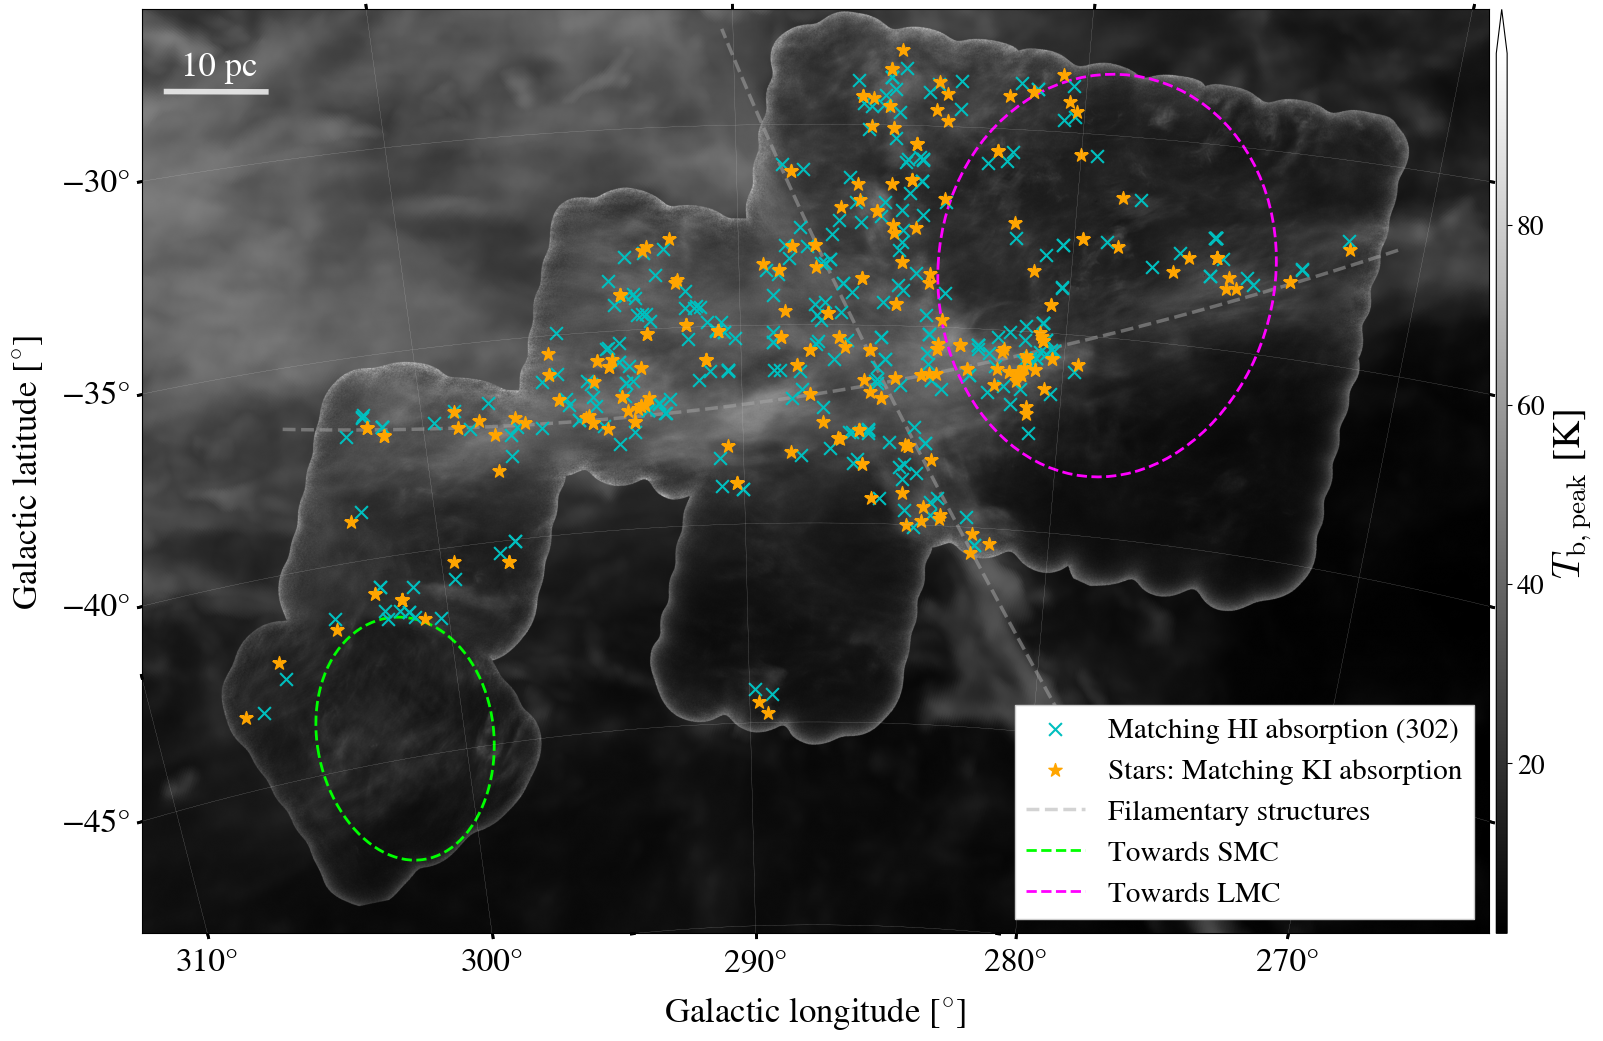

In [ ]:
# Plot
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection=w)

# Display the moment map image
im = ax.imshow(m0, cmap='gray')

ax.scatter(matching_src_glons, matching_src_glats,
           s=85,
           c='c',
           transform=ax.get_transform('galactic'),
           marker='x',
           label=f'Matching HI absorption ({n_matchings})')


ax.scatter(matching_star_glons, matching_star_glats,
           s=100,
           c='orange',
           transform=ax.get_transform('galactic'),
           marker='*',
           label=f'Stars: Matching KI absorption')



ax.plot(ch_xcirc, ch_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label='Filamentary structures'
       )


ax.plot(cv_xcirc, cv_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.5,
        c='darkgray',
        ls='--',
        zorder=0,
        alpha=0.5,
        label=''
       )


# # Approximate locations of LMC, SMC
ax.plot(SMC_xcirc,
        SMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='lime',
        ls='--',
        label='Towards SMC'
       )
ax.plot(LMC_xcirc,
        LMC_ycirc,
        transform=ax.get_transform('galactic'),
        lw=2.,
        zorder=0,
        color='fuchsia',
        ls='--',
        label='Towards LMC'
       )


ax.plot([303., 305.6], [-28.33, -28.], transform=ax.get_transform('galactic'), c='white', lw=4, alpha=0.8, label=f'')
ax.text(304.1, -27.6, '10 pc', dict(size=25, color='white'), horizontalalignment='center',  verticalalignment='center', transform=ax.get_transform('galactic'))



# Title
# ax.set_title('', fontsize=18)

# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)


## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', location='right', extend='max', fraction=0.008, pad=0.005, aspect=85)
cbar.ax.set_ylabel('$T_\mathrm{b,peak}$ [K]', rotation=90, labelpad=5., fontsize=28)
cbar.ax.tick_params(labelsize=20)


# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=25)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=25)

ax.tick_params(axis='x', labelsize=24, pad=4)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)


ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=21)
ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()